In [205]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
# import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [206]:
data = pd.read_pickle('./data_1d.pickle')
select_features = ['user_id','cp_server_no','cp_role_id','role_created_login_num',
       'role_created_active', 'role_created_online',
       'max_role_level', 'ip_num',
       'device_num',
       'pay_num', 'pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'pay_rate', 'pay_avg',
       'model_money_level', 'hour', 'weekend', 'is_holidays','mobile','platform',
       'user_creates_3_server_num','user_creates_3_role_num', 'time_interval']
label = ['role_created_30_pay_sum']
df = data[select_features].join(data[label])
df['role_created_30_pay_sum'].fillna(0,inplace=True)
df['platform'].fillna(0,inplace=True)
df['user_creates_3_server_num'].fillna(1,inplace=True)
df['user_creates_3_role_num'].fillna(1,inplace=True)
df['time_interval'].fillna(0,inplace=True)
df['model_money_level'].fillna(4,inplace=True)

In [207]:
df_pay = df[df['pay_sum']>0]
df_nopay = df[df['pay_sum']==0]
df_nopay_online_n = df_nopay[(df_nopay['role_created_online']==300) | (df_nopay['role_created_login_num']<3)|(df_nopay['max_role_level']==1)]
df_nopay_online_y = df_nopay.loc[np.setdiff1d(df_nopay.index, df_nopay_online_n.index),:]

In [209]:
df_pay['role_created_30_pay_sum'].sum()

83631384.0

In [210]:
df_nopay['role_created_30_pay_sum'].sum()

16289339.0

In [211]:
df_pay['role_created_30_pay_sum'].sum()/(df_pay['role_created_30_pay_sum'].sum()+df_nopay['role_created_30_pay_sum'].sum())

0.836977370550051

In [212]:
print('前n天没有付费的人数：',df_nopay.shape[0])
print('前n天没有付费且不活跃的用户:',df_nopay_online_n.shape[0])
print('前n天没有付费但活跃的用户:',df_nopay_online_y.shape[0])

前n天没有付费的人数： 5061503
前n天没有付费且不活跃的用户: 3701376
前n天没有付费但活跃的用户: 1360127


In [213]:
print('前n天没有付费且不活跃的用户30天付费金额:', df_nopay_online_n['role_created_30_pay_sum'].sum())
print('前n天没有付费但活跃的用户30天付费金额:', df_nopay_online_y['role_created_30_pay_sum'].sum())
print('前n天没有付费但前30天付费的用户人数:',df_nopay_online_y[df_nopay_online_y['role_created_30_pay_sum']>0].shape[0])
print('前n天没有付费但前30天付费的用户人数前30天付费金额:',df_nopay_online_y[df_nopay_online_y['role_created_30_pay_sum']>0]['role_created_30_pay_sum'].mean())

前n天没有付费且不活跃的用户30天付费金额: 2181944.0
前n天没有付费但活跃的用户30天付费金额: 14107395.0
前n天没有付费但前30天付费的用户人数: 41138
前n天没有付费但前30天付费的用户人数前30天付费金额: 342.9285575380427


In [214]:
df_train, df_test = train_test_split(df,test_size=0.3)

In [215]:
df_train_pay = df_train[df_train['pay_sum']>0]
df_train_nopay = df_train[df_train['pay_sum']==0]
df_train_nopay_online_n = df_train_nopay[(df_train_nopay['role_created_online']==300) | (df_train_nopay['role_created_login_num']<3)|(df_train_nopay['max_role_level']==1)]
df_train_nopay_online_y = df_train_nopay.loc[np.setdiff1d(df_train_nopay.index, df_train_nopay_online_n.index),:]

In [216]:
del df_nopay,df_pay,df_nopay_online_n,df_nopay_online_y
gc.collect()

37852

# 在前n天没有付费但活跃的用户中，预测前30天是否会成为付费用户

In [217]:
df_train_nopay_online_y.shape

(952452, 34)

In [218]:
df_train_nopay_online_y['pay_30'] = (df_train_nopay_online_y['role_created_30_pay_sum']>0).astype(int)
df_train_nopay_online_y.drop(['role_created_30_pay_sum'], axis=1, inplace=True)
df_train_nopay_online_y.head()

,user_id,cp_server_no,cp_role_id,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,device_num,pay_num,pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_rate,pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,pay_30
18,90002408,660011,12927613,7.04,1.0,4704.0,16.0,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,4.0,13,4,0,0,1.0,1.0,1.0,0.0,0
24,90002604,660011,12927619,5.28,1.0,3528.0,12.0,1.0,1.0,0.0,0.0,0,0,5,0,0,0,0,0,0,0,0,0.0,0.0,2.0,13,4,0,0,1.0,1.0,1.0,0.0,0
29,90002769,660011,12927624,8.00,1.0,28800.0,42.0,1.0,1.0,0.0,0.0,31,27,19,8,18,0,0,0,0,0,0,0.0,0.0,1.0,13,4,0,0,1.0,1.0,1.0,0.0,1
34,90002980,660011,12927628,3.00,1.0,1810.0,9.0,1.0,1.0,0.0,0.0,0,0,4,5,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,0,1.0,1.0,1.0,0.0,0
35,90003019,660011,12927630,8.80,1.0,4564.0,20.0,1.0,1.0,0.0,0.0,0,0,13,3,0,0,0,0,0,0,0,0.0,0.0,0.0,13,4,0,0,1.0,1.0,1.0,0.0,0


In [219]:
df_train_nopay_online_y['pay_30'].value_counts()

0    923632
1     28820
Name: pay_30, dtype: int64

In [220]:
target = df_train_nopay_online_y['pay_30']
features = df_train_nopay_online_y.drop(['pay_30','user_id','cp_server_no','cp_role_id'], axis=1)

from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()         #实例化，不填参数默认方差为0
features = selector.fit_transform(features)         #获取删除不合格特征之后的新特征矩阵

X_val, x_test, Y_val, y_test = train_test_split(features,target, test_size=0.3)

In [221]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=0)
X_val, Y_val = smo.fit_sample(X_val, Y_val)

In [222]:
Y_val.value_counts()

1    646606
0    646606
Name: pay_30, dtype: int64

In [229]:
# 不调参
params = {
"objective": "binary",
"boosting_type": "gbdt",
"learning_rate": 0.03,
"max_depth":3,
"num_leaves":35,
"min_child_samples":15,
"feature_fraction": 0.7,
"bagging_fraction":0.7,
"bagging_freq":10,
"lambda_l1":2,
"lambda_l2":2,
"metric": "auc",
# "is_unbalance":True
}

train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_b = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's auc: 0.892825	valid_1's auc: 0.813655
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.91522	valid_1's auc: 0.840389
[3]	training's auc: 0.921894	valid_1's auc: 0.846017
[4]	training's auc: 0.926179	valid_1's auc: 0.854581
[5]	training's auc: 0.92624	valid_1's auc: 0.855696
[6]	training's auc: 0.926958	valid_1's auc: 0.856193
[7]	training's auc: 0.927357	valid_1's auc: 0.855909
[8]	training's auc: 0.929023	valid_1's auc: 0.859734
[9]	training's auc: 0.931305	valid_1's auc: 0.860652
[10]	training's auc: 0.933773	valid_1's auc: 0.861027
[11]	training's auc: 0.934982	valid_1's auc: 0.862632
[12]	training's auc: 0.935967	valid_1's auc: 0.862374
[13]	training's auc: 0.936182	valid_1's auc: 0.861935
[14]	training's auc: 0.936552	valid_1's auc: 0.862525
[15]	training's auc: 0.936705	valid_1's auc: 0.86275
[16]	training's auc: 0.936478	valid_1's auc: 0.862865
[17]	training's auc: 0.936766	valid_1's auc: 0.862544
[18]	training's auc: 0.937286	va

[152]	training's auc: 0.977345	valid_1's auc: 0.866631
[153]	training's auc: 0.977488	valid_1's auc: 0.866444
[154]	training's auc: 0.977601	valid_1's auc: 0.866499
[155]	training's auc: 0.977827	valid_1's auc: 0.866444
[156]	training's auc: 0.977926	valid_1's auc: 0.866215
[157]	training's auc: 0.978116	valid_1's auc: 0.866179
[158]	training's auc: 0.978315	valid_1's auc: 0.866122
[159]	training's auc: 0.978413	valid_1's auc: 0.866161
[160]	training's auc: 0.978555	valid_1's auc: 0.866085
[161]	training's auc: 0.978647	valid_1's auc: 0.865942
[162]	training's auc: 0.978702	valid_1's auc: 0.86596
[163]	training's auc: 0.978803	valid_1's auc: 0.865897
[164]	training's auc: 0.978993	valid_1's auc: 0.865788
[165]	training's auc: 0.979164	valid_1's auc: 0.865757
[166]	training's auc: 0.979475	valid_1's auc: 0.865752
[167]	training's auc: 0.979835	valid_1's auc: 0.865789
[168]	training's auc: 0.979996	valid_1's auc: 0.865681
[169]	training's auc: 0.980159	valid_1's auc: 0.865614
[170]	train

In [281]:
# 用df_test数据集进行测试
df_test_pay = df_test[df_test['pay_sum']>0]
df_test_nopay = df_test[df_test['pay_sum']==0]
df_test_nopay_online_n = df_test_nopay[(df_test_nopay['role_created_online']==300) | (df_test_nopay['role_created_login_num']<3)|(df_test_nopay['max_role_level']==1)]
df_test_nopay_online_y = df_test_nopay.loc[np.setdiff1d(df_test_nopay.index, df_test_nopay_online_n.index),:]
df_test_nopay_online_y['pay_30'] = (df_test_nopay_online_y['role_created_30_pay_sum']>0).astype(int)
df_test_nopay_online_y.drop(['role_created_30_pay_sum'], axis=1, inplace=True)

target_test = df_test_nopay_online_y['pay_30']
features_test = df_test_nopay_online_y.drop(['pay_30','user_id','cp_server_no','cp_role_id'], axis=1)
features_test = selector.fit_transform(features_test)  
y_predict = lgb_b.predict(features_test)

In [282]:
sessoin = pd.DataFrame(y_predict, columns=['pay_30'])
sessoin['pay_30']=sessoin['pay_30'].apply(lambda x:1 if x>=0.4 else 0)
y_predict_val = sessoin['pay_30'].values
print(recall_score(target_test, y_predict_val, average=None))
print(precision_score(target_test, y_predict_val))
print(accuracy_score(target_test, y_predict_val))
print(f1_score(target_test, y_predict_val))

[0.80860336 0.78998214]
0.11394480158311963
0.8080407187097566
0.19916290588319568


In [283]:
sessoin = pd.DataFrame(y_predict, columns=['pay_30'])
sessoin['pay_30']=sessoin['pay_30'].apply(lambda x:1 if x>=0.6 else 0)
y_predict_val = sessoin['pay_30'].values
print(recall_score(target_test, y_predict_val, average=None))
print(precision_score(target_test, y_predict_val))
print(accuracy_score(target_test, y_predict_val))
print(f1_score(target_test, y_predict_val))

[0.90470385 0.5275207 ]
0.1471001041336533
0.893307168700558
0.23005027260497066


In [233]:
from sklearn.metrics import auc,roc_curve,roc_auc_score
fpr,tpr,thresholds = roc_curve(target_test,y_predict_val)
roc_auc = auc(fpr,tpr)
roc_auc
# test_auc = roc_auc_score(target_test,y_predict_val)
# print(test_auc)

0.7161122756753622

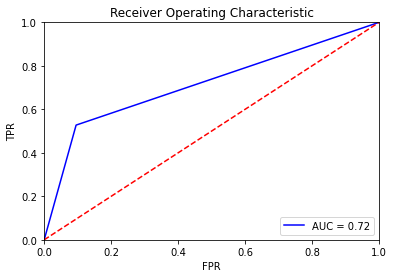

In [234]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [235]:
thresholds = [0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
thresholds_2 = thresholds[:]
result_model_f1 = pd.DataFrame(index=thresholds_2)
# print(result_model_f1)
for i in thresholds:
    y_test_predictions_high_recall = y_predict > i
    result_model_f1.loc[i, 'lgb_b'] = f1_score(target_test, y_test_predictions_high_recall)
print(result_model_f1)

         lgb_b
0.10  0.064001
0.20  0.146588
0.25  0.162138
0.30  0.174238
0.35  0.187343
0.40  0.199163
0.45  0.210083
0.50  0.218292
0.55  0.226221
0.60  0.230050
0.65  0.235299
0.70  0.231889
0.75  0.215264
0.80  0.142792
0.85  0.102612
0.90  0.000000


## 前1天有付费的用户进行回归

In [236]:
pd.set_option('display.max_columns',None)
df_train_pay.head()

,user_id,cp_server_no,cp_role_id,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,device_num,pay_num,pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_rate,pay_avg,model_money_level,hour,weekend,is_holidays,mobile,platform,user_creates_3_server_num,user_creates_3_role_num,time_interval,role_created_30_pay_sum
3902582,104274329,660709,14844470,3.0,1.0,2493.0,36.0000,2.0,1.0,1.0,30.0,1,0,0,1,8,0,1,0,0,0,0,0.9999,29.997000,4.0,20,6,0,0,1.0,2.0,2.0,7.0,30.0
1384839,103806016,660318,14708895,13.0,1.0,28800.0,45.0000,1.0,1.0,3.0,72.0,19,10,8,22,44,0,3,0,0,0,0,2.9997,23.999200,2.0,20,2,0,1,1.0,3.0,3.0,0.0,72.0
2118851,15141369,660416,15418045,3.0,1.0,28800.0,34.0000,2.0,1.0,1.0,12.0,62,0,0,0,40,0,1,0,0,0,0,0.9999,11.998800,4.0,21,4,0,0,0.0,1.0,1.0,0.0,42.0
495768,98201363,660113,13482598,27.0,1.0,28800.0,51.0000,10.0,1.0,13.0,1290.0,82,23,12,41,52,0,6,5,1,0,1,12.9987,99.230006,1.0,15,1,0,0,1.0,1.0,1.0,0.0,3274.0
1952953,105460324,660390,15257640,28.0,1.0,16692.0,51.7452,2.0,1.0,2.0,42.0,5,12,0,7,23,0,2,0,0,0,0,1.9998,20.998950,5.0,12,1,0,0,2.0,1.0,1.0,0.0,42.0


In [237]:
target = df_train_pay['role_created_30_pay_sum']
features = df_train_pay.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
target_ln = np.log1p(target)
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)

In [78]:
# lgb的调参与交叉验证
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# 设置参数初始值，不含交叉验证参数
print('设置参数')
params = {
    'boosting_type':'gbdt',
    'objective':'regression',
    'metric':'rmse',
    'nthread':4,
    'learning_rate':0.05
}

# 交叉验证（调参）
print('交叉验证')
min_rmse = float('2')
best_params = {}

# 准确率
print('调参1：提高准确率')
for num_leaves in range(5, 100, 5):
    for max_depth in range(3, 8, 1):
        params['num_leaves'] = num_leaves
        params['max_depth'] = max_depth
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50     
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['num_leaves'] = num_leaves
            best_params['max_depth'] = max_depth

if 'num_leaves' and 'max_depth' in best_params.keys():
    params['num_leaves'] = best_params['num_leaves']
    params['max_depth'] = best_params['max_depth']

# 过拟合
print('调参2：降低过拟合')
for max_bin in range(5, 256, 10):
    for min_data_in_leaf in range(1, 102, 10):
        params['max_bin'] = max_bin
        params['min_data_in_leaf'] = min_data_in_leaf
        
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50 
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['min_data_in_leaf'] = min_data_in_leaf
            best_params['max_bin'] = max_bin
            
if 'max_bin' and 'min_data_in_leaf' in best_params.keys():
    params['max_bin'] = best_params['max_bin']
    params['min_data_in_leaf'] = best_params['min_data_in_leaf']

print('调参3：降低过拟合')
for feature_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    for bagging_fraction in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for bagging_freq in range(0,50,5):
            params['feature_fraction'] = feature_fraction
            params['bagging_fraction'] = bagging_fraction
            params['bagging_freq'] = bagging_freq

            cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50
                            )
            mean_rmse = pd.Series(cv_results['rmse-mean']).min()
            boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
            if mean_rmse <= min_rmse:
                min_rmse = mean_rmse
                best_params['feature_fraction'] = feature_fraction
                best_params['bagging_fraction'] = bagging_fraction
                best_params['bagging_freq'] = bagging_freq

if 'feature_fraction' and 'bagging_fraction' and 'bagging_freq' in best_params.keys():
    params['feature_fraction'] = best_params['feature_fraction']
    params['bagging_fraction'] = best_params['bagging_fraction']
    params['bagging_freq'] = best_params['bagging_freq']

print('调参4：降低过拟合')

for lambda_l1 in [1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]:
    for lambda_l2 in [1e-5,1e-3,1e-1,0.0,0.1,0.4,0.6,0.7,0.9,1.0]:
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
        cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50
                            )
        mean_rmse = pd.Series(cv_results['rmse-mean']).min()
        boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
        if mean_rmse <= min_rmse:
            min_rmse = mean_rmse
            best_params['lambda_l1'] = lambda_l1
            best_params['lambda_l2'] = lambda_l2
if 'lambda_l1' and 'lambda_l2' in best_params.keys():
    params['lambda_l1'] = best_params['lambda_l1']
    params['lambda_l2'] = best_params['lambda_l2']

print("调参5：降低过拟合2")
for min_split_gain in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
    params['min_split_gain'] = min_split_gain
    
    cv_results = lgb.cv(
                            params,
                            train_data,
                            nfold=3,
                            stratified=False,
                            early_stopping_rounds=10,
                            verbose_eval=50    
                            )
    mean_rmse = pd.Series(cv_results['rmse-mean']).min()
    boost_rounds = pd.Series(cv_results['rmse-mean']).idxmin()
        
    if mean_rmse >= min_rmse:
        min_rmse = mean_rmse
        
    best_params['min_split_gain'] = min_split_gain
if 'min_split_gain' in best_params.keys():
    params['min_split_gain'] = best_params['min_split_gain']
print(best_params)

设置参数
交叉验证
调参1：提高准确率
[50]	cv_agg's rmse: 1.20181 + 0.00480978
[100]	cv_agg's rmse: 1.17714 + 0.00597052
[50]	cv_agg's rmse: 1.20192 + 0.00482968
[100]	cv_agg's rmse: 1.17697 + 0.00613404
[50]	cv_agg's rmse: 1.20192 + 0.00482968
[100]	cv_agg's rmse: 1.17697 + 0.00613404
[50]	cv_agg's rmse: 1.20192 + 0.00482968
[100]	cv_agg's rmse: 1.17697 + 0.00613404
[50]	cv_agg's rmse: 1.20192 + 0.00482968
[100]	cv_agg's rmse: 1.17697 + 0.00613404
[50]	cv_agg's rmse: 1.19341 + 0.00492066
[100]	cv_agg's rmse: 1.17427 + 0.00608116
[50]	cv_agg's rmse: 1.18882 + 0.00503475
[100]	cv_agg's rmse: 1.17225 + 0.00606247
[50]	cv_agg's rmse: 1.18849 + 0.00521217
[100]	cv_agg's rmse: 1.17174 + 0.00609148
[50]	cv_agg's rmse: 1.18848 + 0.00521697
[100]	cv_agg's rmse: 1.17161 + 0.0060749
[50]	cv_agg's rmse: 1.18848 + 0.00521697
[100]	cv_agg's rmse: 1.17178 + 0.0062195
[50]	cv_agg's rmse: 1.19341 + 0.00492066
[100]	cv_agg's rmse: 1.17427 + 0.00608116
[50]	cv_agg's rmse: 1.18529 + 0.00511806
[100]	cv_agg's rmse: 1.17125

[50]	cv_agg's rmse: 1.18103 + 0.00564707
[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg's rmse: 1.18156 + 0.0057475
[100]	cv_agg's rmse: 1.16993 + 0.00604834
[50]	cv_agg's rmse: 1.18152 + 0.00572351
[100]	cv_agg's rmse: 1.17058 + 0.00653995
[50]	cv_agg's rmse: 1.18169 + 0.00558734
[100]	cv_agg's rmse: 1.17041 + 0.00623965
[50]	cv_agg's rmse: 1.18166 + 0.00558796
[100]	cv_agg's rmse: 1.17054 + 0.00638264
[50]	cv_agg's rmse: 1.18158 + 0.00562532
[100]	cv_agg's rmse: 1.17049 + 0.00655023
[50]	cv_agg's rmse: 1.18163 + 0.0057836
[100]	cv_agg's rmse: 1.17058 + 0.00646751
[50]	cv_agg's rmse: 1.18145 + 0.00579374
[100]	cv_agg's rmse: 1.17042 + 0.00676857
[50]	cv_agg's rmse: 1.18084 + 0.00561545
[100]	cv_agg's rmse: 1.16956 + 0.006644
[50]	cv_agg's rmse: 1.18101 + 0.00559106
[100]	cv_agg's rmse: 1.16974 + 0.00639653
[50]	cv_agg's rmse: 1.1811 + 0.00580504
[100]	cv_agg's rmse: 1.16952 + 0.00633329
[50]	cv_agg's rmse: 1.18103 + 0.00564707
[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg

[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg's rmse: 1.18156 + 0.0057475
[100]	cv_agg's rmse: 1.16993 + 0.00604834
[50]	cv_agg's rmse: 1.18152 + 0.00572351
[100]	cv_agg's rmse: 1.17058 + 0.00653995
[50]	cv_agg's rmse: 1.18169 + 0.00558734
[100]	cv_agg's rmse: 1.17041 + 0.00623965
[50]	cv_agg's rmse: 1.18166 + 0.00558796
[100]	cv_agg's rmse: 1.17054 + 0.00638264
[50]	cv_agg's rmse: 1.18158 + 0.00562532
[100]	cv_agg's rmse: 1.17049 + 0.00655023
[50]	cv_agg's rmse: 1.18163 + 0.0057836
[100]	cv_agg's rmse: 1.17058 + 0.00646751
[50]	cv_agg's rmse: 1.18145 + 0.00579374
[100]	cv_agg's rmse: 1.17042 + 0.00676857
[50]	cv_agg's rmse: 1.18084 + 0.00561545
[100]	cv_agg's rmse: 1.16956 + 0.006644
[50]	cv_agg's rmse: 1.18101 + 0.00559106
[100]	cv_agg's rmse: 1.16974 + 0.00639653
[50]	cv_agg's rmse: 1.1811 + 0.00580504
[100]	cv_agg's rmse: 1.16952 + 0.00633329
[50]	cv_agg's rmse: 1.18103 + 0.00564707
[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg's rmse: 1.18156 + 0.0057475
[100]	cv_agg

[50]	cv_agg's rmse: 1.18156 + 0.0057475
[100]	cv_agg's rmse: 1.16993 + 0.00604834
[50]	cv_agg's rmse: 1.18152 + 0.00572351
[100]	cv_agg's rmse: 1.17058 + 0.00653995
[50]	cv_agg's rmse: 1.18169 + 0.00558734
[100]	cv_agg's rmse: 1.17041 + 0.00623965
[50]	cv_agg's rmse: 1.18166 + 0.00558796
[100]	cv_agg's rmse: 1.17054 + 0.00638264
[50]	cv_agg's rmse: 1.18158 + 0.00562532
[100]	cv_agg's rmse: 1.17049 + 0.00655023
[50]	cv_agg's rmse: 1.18163 + 0.0057836
[100]	cv_agg's rmse: 1.17058 + 0.00646751
[50]	cv_agg's rmse: 1.18145 + 0.00579374
[100]	cv_agg's rmse: 1.17042 + 0.00676857
[50]	cv_agg's rmse: 1.18084 + 0.00561545
[100]	cv_agg's rmse: 1.16956 + 0.006644
[50]	cv_agg's rmse: 1.18101 + 0.00559106
[100]	cv_agg's rmse: 1.16974 + 0.00639653
[50]	cv_agg's rmse: 1.1811 + 0.00580504
[100]	cv_agg's rmse: 1.16952 + 0.00633329
[50]	cv_agg's rmse: 1.18103 + 0.00564707
[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg's rmse: 1.18156 + 0.0057475
[100]	cv_agg's rmse: 1.16993 + 0.00604834
[50]	cv_agg

[100]	cv_agg's rmse: 1.17275 + 0.00621698
[50]	cv_agg's rmse: 1.18489 + 0.00539982
[100]	cv_agg's rmse: 1.17311 + 0.00601657
[50]	cv_agg's rmse: 1.18429 + 0.00595026
[100]	cv_agg's rmse: 1.17286 + 0.00655596
[50]	cv_agg's rmse: 1.18456 + 0.00624502
[100]	cv_agg's rmse: 1.17352 + 0.00673965
[50]	cv_agg's rmse: 1.18383 + 0.00506951
[100]	cv_agg's rmse: 1.17093 + 0.00551988
[50]	cv_agg's rmse: 1.18386 + 0.00536209
[100]	cv_agg's rmse: 1.17118 + 0.00574786
[50]	cv_agg's rmse: 1.18396 + 0.00558231
[100]	cv_agg's rmse: 1.1719 + 0.00580152
[50]	cv_agg's rmse: 1.18383 + 0.00577285
[100]	cv_agg's rmse: 1.17217 + 0.00638174
[50]	cv_agg's rmse: 1.18422 + 0.00552801
[100]	cv_agg's rmse: 1.17192 + 0.00621219
[50]	cv_agg's rmse: 1.18406 + 0.00540837
[100]	cv_agg's rmse: 1.17237 + 0.00557726
[50]	cv_agg's rmse: 1.18405 + 0.00524989
[100]	cv_agg's rmse: 1.1723 + 0.00559189
[50]	cv_agg's rmse: 1.18437 + 0.00531695
[100]	cv_agg's rmse: 1.17252 + 0.00573315
[50]	cv_agg's rmse: 1.18385 + 0.00583007
[100]	

[50]	cv_agg's rmse: 1.18296 + 0.00538755
[100]	cv_agg's rmse: 1.17069 + 0.00612333
[50]	cv_agg's rmse: 1.18296 + 0.00538755
[100]	cv_agg's rmse: 1.17069 + 0.00612333
[50]	cv_agg's rmse: 1.18296 + 0.00538755
[100]	cv_agg's rmse: 1.17069 + 0.00612333
[50]	cv_agg's rmse: 1.18296 + 0.00538755
[100]	cv_agg's rmse: 1.17069 + 0.00612333
[50]	cv_agg's rmse: 1.18234 + 0.00511883
[100]	cv_agg's rmse: 1.17044 + 0.00608022
[50]	cv_agg's rmse: 1.18225 + 0.00586248
[100]	cv_agg's rmse: 1.17137 + 0.00587728
[50]	cv_agg's rmse: 1.18306 + 0.00636159
[100]	cv_agg's rmse: 1.17232 + 0.00601932
[50]	cv_agg's rmse: 1.18323 + 0.00603859
[100]	cv_agg's rmse: 1.17284 + 0.00623878
[50]	cv_agg's rmse: 1.18376 + 0.00599539
[100]	cv_agg's rmse: 1.17318 + 0.00619349
[50]	cv_agg's rmse: 1.18382 + 0.00547465
[100]	cv_agg's rmse: 1.17332 + 0.00647127
[50]	cv_agg's rmse: 1.18334 + 0.00589641
[100]	cv_agg's rmse: 1.17342 + 0.00662112
[50]	cv_agg's rmse: 1.18306 + 0.00581174
[100]	cv_agg's rmse: 1.17239 + 0.00672894
[50]

[100]	cv_agg's rmse: 1.17145 + 0.00558464
[50]	cv_agg's rmse: 1.1827 + 0.00533868
[100]	cv_agg's rmse: 1.17121 + 0.00538402
[50]	cv_agg's rmse: 1.18291 + 0.00526729
[100]	cv_agg's rmse: 1.17164 + 0.00569411
[50]	cv_agg's rmse: 1.18251 + 0.00532401
[100]	cv_agg's rmse: 1.17158 + 0.00608281
[50]	cv_agg's rmse: 1.18259 + 0.00523062
[100]	cv_agg's rmse: 1.17117 + 0.00644977
[50]	cv_agg's rmse: 1.18214 + 0.00554799
[100]	cv_agg's rmse: 1.16984 + 0.00593447
[50]	cv_agg's rmse: 1.18197 + 0.00549324
[100]	cv_agg's rmse: 1.16954 + 0.00620057
[50]	cv_agg's rmse: 1.18238 + 0.00548039
[100]	cv_agg's rmse: 1.17035 + 0.006344
[50]	cv_agg's rmse: 1.18241 + 0.00517323
[100]	cv_agg's rmse: 1.17038 + 0.0058866
[50]	cv_agg's rmse: 1.18231 + 0.00547101
[100]	cv_agg's rmse: 1.17014 + 0.00647372
[50]	cv_agg's rmse: 1.18265 + 0.00507566
[100]	cv_agg's rmse: 1.17052 + 0.00578126
[50]	cv_agg's rmse: 1.18231 + 0.00491179
[100]	cv_agg's rmse: 1.17025 + 0.00584744
[50]	cv_agg's rmse: 1.18249 + 0.00521331
[100]	cv

[50]	cv_agg's rmse: 1.18312 + 0.00580835
[100]	cv_agg's rmse: 1.17277 + 0.00599995
[50]	cv_agg's rmse: 1.18256 + 0.00669923
[100]	cv_agg's rmse: 1.17258 + 0.00673121
[50]	cv_agg's rmse: 1.18347 + 0.00586443
[100]	cv_agg's rmse: 1.17336 + 0.00667177
[50]	cv_agg's rmse: 1.18291 + 0.00586904
[100]	cv_agg's rmse: 1.17312 + 0.00620171
[50]	cv_agg's rmse: 1.18318 + 0.00578721
[100]	cv_agg's rmse: 1.17302 + 0.00612301
[50]	cv_agg's rmse: 1.18103 + 0.00564707
[100]	cv_agg's rmse: 1.1695 + 0.00653465
[50]	cv_agg's rmse: 1.18193 + 0.00558562
[100]	cv_agg's rmse: 1.17098 + 0.00624782
[50]	cv_agg's rmse: 1.18208 + 0.00555419
[100]	cv_agg's rmse: 1.17144 + 0.00602783
[50]	cv_agg's rmse: 1.18208 + 0.00567515
[100]	cv_agg's rmse: 1.1714 + 0.0060769
[50]	cv_agg's rmse: 1.18209 + 0.00544449
[100]	cv_agg's rmse: 1.17124 + 0.00674799
[50]	cv_agg's rmse: 1.18265 + 0.00510996
[100]	cv_agg's rmse: 1.17234 + 0.00557378
[50]	cv_agg's rmse: 1.1826 + 0.00569515
[100]	cv_agg's rmse: 1.17257 + 0.00615257
[50]	cv_

[100]	cv_agg's rmse: 1.16971 + 0.00656326
[50]	cv_agg's rmse: 1.18169 + 0.00546304
[100]	cv_agg's rmse: 1.16971 + 0.00663214
[50]	cv_agg's rmse: 1.18159 + 0.00554513
[100]	cv_agg's rmse: 1.16961 + 0.00655078
[50]	cv_agg's rmse: 1.18186 + 0.00554062
[100]	cv_agg's rmse: 1.16976 + 0.00671905
[50]	cv_agg's rmse: 1.18181 + 0.00556888
[100]	cv_agg's rmse: 1.17002 + 0.00671676
[50]	cv_agg's rmse: 1.18183 + 0.00556745
[100]	cv_agg's rmse: 1.17 + 0.00666806
[50]	cv_agg's rmse: 1.18183 + 0.00560397
[100]	cv_agg's rmse: 1.16978 + 0.00685312
[50]	cv_agg's rmse: 1.18183 + 0.00560396
[100]	cv_agg's rmse: 1.16978 + 0.00685311
[50]	cv_agg's rmse: 1.18168 + 0.00563071
[100]	cv_agg's rmse: 1.17001 + 0.00699387
[50]	cv_agg's rmse: 1.18183 + 0.00560397
[100]	cv_agg's rmse: 1.16978 + 0.00685313
[50]	cv_agg's rmse: 1.18168 + 0.00563071
[100]	cv_agg's rmse: 1.17001 + 0.00699387
[50]	cv_agg's rmse: 1.18167 + 0.00542507
[100]	cv_agg's rmse: 1.16985 + 0.0063693
[50]	cv_agg's rmse: 1.18175 + 0.00551159
[100]	cv

In [ ]:
# {'num_leaves': 25, 'max_depth': 7, 'min_data_in_leaf': 41, 'max_bin': 255, 'feature_fraction': 1.0, 'bagging_fraction': 0.9, 'bagging_freq': 20, 'lambda_l1': 0.001, 'lambda_l2': 0.4, 'min_split_gain': 1.0}

In [255]:
params = {

'boosting_type':'gbdt',
'objective':'regression',
'metric':'rmse',
'nthread':4,
'learning_rate':0.005,
"max_depth":7,
"num_leaves":25,
"max_bin":255,
"min_data_in_leaf":61,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":0.9,
"bagging_freq":20,
"lambda_l1":0.001,
"lambda_l2":0.4,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_r_cv = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.82169	valid_1's rmse: 1.82638
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.8165	valid_1's rmse: 1.8211
[3]	training's rmse: 1.81135	valid_1's rmse: 1.81586
[4]	training's rmse: 1.80624	valid_1's rmse: 1.81065
[5]	training's rmse: 1.80116	valid_1's rmse: 1.80549
[6]	training's rmse: 1.79612	valid_1's rmse: 1.80035
[7]	training's rmse: 1.79112	valid_1's rmse: 1.79526
[8]	training's rmse: 1.78615	valid_1's rmse: 1.7902
[9]	training's rmse: 1.78121	valid_1's rmse: 1.78518
[10]	training's rmse: 1.77632	valid_1's rmse: 1.7802
[11]	training's rmse: 1.77145	valid_1's rmse: 1.77525
[12]	training's rmse: 1.76663	valid_1's rmse: 1.77033
[13]	training's rmse: 1.76182	valid_1's rmse: 1.76545
[14]	training's rmse: 1.75707	valid_1's rmse: 1.7606
[15]	training's rmse: 1.75234	valid_1's rmse: 1.75579
[16]	training's rmse: 1.74764	valid_1's rmse: 1.75101
[17]	training's rmse: 1.74299	valid_1's rmse: 1.74627
[18]	training's rmse: 1.73836	vali

[192]	training's rmse: 1.29992	valid_1's rmse: 1.29444
[193]	training's rmse: 1.29879	valid_1's rmse: 1.29329
[194]	training's rmse: 1.29767	valid_1's rmse: 1.29216
[195]	training's rmse: 1.29656	valid_1's rmse: 1.29103
[196]	training's rmse: 1.29546	valid_1's rmse: 1.28991
[197]	training's rmse: 1.29437	valid_1's rmse: 1.28881
[198]	training's rmse: 1.29329	valid_1's rmse: 1.28771
[199]	training's rmse: 1.29221	valid_1's rmse: 1.28662
[200]	training's rmse: 1.29115	valid_1's rmse: 1.28554
[201]	training's rmse: 1.29009	valid_1's rmse: 1.28444
[202]	training's rmse: 1.28904	valid_1's rmse: 1.28337
[203]	training's rmse: 1.28801	valid_1's rmse: 1.28231
[204]	training's rmse: 1.28698	valid_1's rmse: 1.28125
[205]	training's rmse: 1.28596	valid_1's rmse: 1.28021
[206]	training's rmse: 1.28495	valid_1's rmse: 1.27917
[207]	training's rmse: 1.28395	valid_1's rmse: 1.27814
[208]	training's rmse: 1.28296	valid_1's rmse: 1.27712
[209]	training's rmse: 1.28197	valid_1's rmse: 1.27612
[210]	trai

[387]	training's rmse: 1.19308	valid_1's rmse: 1.1873
[388]	training's rmse: 1.19286	valid_1's rmse: 1.18709
[389]	training's rmse: 1.19265	valid_1's rmse: 1.18689
[390]	training's rmse: 1.19244	valid_1's rmse: 1.18669
[391]	training's rmse: 1.19223	valid_1's rmse: 1.18649
[392]	training's rmse: 1.19202	valid_1's rmse: 1.18629
[393]	training's rmse: 1.19181	valid_1's rmse: 1.1861
[394]	training's rmse: 1.19161	valid_1's rmse: 1.1859
[395]	training's rmse: 1.1914	valid_1's rmse: 1.1857
[396]	training's rmse: 1.1912	valid_1's rmse: 1.18551
[397]	training's rmse: 1.191	valid_1's rmse: 1.18531
[398]	training's rmse: 1.19079	valid_1's rmse: 1.18511
[399]	training's rmse: 1.19059	valid_1's rmse: 1.18492
[400]	training's rmse: 1.1904	valid_1's rmse: 1.18473
[401]	training's rmse: 1.1902	valid_1's rmse: 1.18456
[402]	training's rmse: 1.19002	valid_1's rmse: 1.18439
[403]	training's rmse: 1.18982	valid_1's rmse: 1.18421
[404]	training's rmse: 1.18964	valid_1's rmse: 1.18404
[405]	training's rms

[596]	training's rmse: 1.16877	valid_1's rmse: 1.16658
[597]	training's rmse: 1.1687	valid_1's rmse: 1.16654
[598]	training's rmse: 1.16864	valid_1's rmse: 1.1665
[599]	training's rmse: 1.16857	valid_1's rmse: 1.16646
[600]	training's rmse: 1.16851	valid_1's rmse: 1.16642
[601]	training's rmse: 1.16845	valid_1's rmse: 1.16637
[602]	training's rmse: 1.16839	valid_1's rmse: 1.16633
[603]	training's rmse: 1.16832	valid_1's rmse: 1.16629
[604]	training's rmse: 1.16826	valid_1's rmse: 1.16624
[605]	training's rmse: 1.1682	valid_1's rmse: 1.1662
[606]	training's rmse: 1.16814	valid_1's rmse: 1.16615
[607]	training's rmse: 1.16808	valid_1's rmse: 1.16611
[608]	training's rmse: 1.16803	valid_1's rmse: 1.16607
[609]	training's rmse: 1.16797	valid_1's rmse: 1.16602
[610]	training's rmse: 1.16791	valid_1's rmse: 1.16598
[611]	training's rmse: 1.16786	valid_1's rmse: 1.16594
[612]	training's rmse: 1.1678	valid_1's rmse: 1.16589
[613]	training's rmse: 1.16774	valid_1's rmse: 1.16585
[614]	training'

[745]	training's rmse: 1.16136	valid_1's rmse: 1.16241
[746]	training's rmse: 1.16131	valid_1's rmse: 1.16239
[747]	training's rmse: 1.16127	valid_1's rmse: 1.16238
[748]	training's rmse: 1.16123	valid_1's rmse: 1.16235
[749]	training's rmse: 1.16119	valid_1's rmse: 1.16233
[750]	training's rmse: 1.16115	valid_1's rmse: 1.16232
[751]	training's rmse: 1.16111	valid_1's rmse: 1.1623
[752]	training's rmse: 1.16107	valid_1's rmse: 1.16228
[753]	training's rmse: 1.16103	valid_1's rmse: 1.16226
[754]	training's rmse: 1.16099	valid_1's rmse: 1.16224
[755]	training's rmse: 1.16095	valid_1's rmse: 1.16223
[756]	training's rmse: 1.16091	valid_1's rmse: 1.16221
[757]	training's rmse: 1.16088	valid_1's rmse: 1.16219
[758]	training's rmse: 1.16084	valid_1's rmse: 1.16218
[759]	training's rmse: 1.1608	valid_1's rmse: 1.16216
[760]	training's rmse: 1.16077	valid_1's rmse: 1.16214
[761]	training's rmse: 1.16073	valid_1's rmse: 1.16213
[762]	training's rmse: 1.1607	valid_1's rmse: 1.16211
[763]	trainin

[904]	training's rmse: 1.15558	valid_1's rmse: 1.16019
[905]	training's rmse: 1.15554	valid_1's rmse: 1.16018
[906]	training's rmse: 1.1555	valid_1's rmse: 1.16017
[907]	training's rmse: 1.15546	valid_1's rmse: 1.16016
[908]	training's rmse: 1.15542	valid_1's rmse: 1.16015
[909]	training's rmse: 1.15539	valid_1's rmse: 1.16014
[910]	training's rmse: 1.15535	valid_1's rmse: 1.16013
[911]	training's rmse: 1.15532	valid_1's rmse: 1.16013
[912]	training's rmse: 1.15528	valid_1's rmse: 1.16012
[913]	training's rmse: 1.15524	valid_1's rmse: 1.1601
[914]	training's rmse: 1.15521	valid_1's rmse: 1.16009
[915]	training's rmse: 1.15517	valid_1's rmse: 1.16008
[916]	training's rmse: 1.15514	valid_1's rmse: 1.16007
[917]	training's rmse: 1.1551	valid_1's rmse: 1.16006
[918]	training's rmse: 1.15507	valid_1's rmse: 1.16006
[919]	training's rmse: 1.15503	valid_1's rmse: 1.16005
[920]	training's rmse: 1.15499	valid_1's rmse: 1.16004
[921]	training's rmse: 1.15496	valid_1's rmse: 1.16003
[922]	trainin

[1075]	training's rmse: 1.14971	valid_1's rmse: 1.15868
[1076]	training's rmse: 1.14969	valid_1's rmse: 1.15867
[1077]	training's rmse: 1.14965	valid_1's rmse: 1.15867
[1078]	training's rmse: 1.14962	valid_1's rmse: 1.15866
[1079]	training's rmse: 1.14959	valid_1's rmse: 1.15866
[1080]	training's rmse: 1.14956	valid_1's rmse: 1.15865
[1081]	training's rmse: 1.14953	valid_1's rmse: 1.15864
[1082]	training's rmse: 1.1495	valid_1's rmse: 1.15864
[1083]	training's rmse: 1.14947	valid_1's rmse: 1.15863
[1084]	training's rmse: 1.14944	valid_1's rmse: 1.15862
[1085]	training's rmse: 1.14941	valid_1's rmse: 1.15862
[1086]	training's rmse: 1.14938	valid_1's rmse: 1.15861
[1087]	training's rmse: 1.14935	valid_1's rmse: 1.15861
[1088]	training's rmse: 1.14932	valid_1's rmse: 1.1586
[1089]	training's rmse: 1.1493	valid_1's rmse: 1.1586
[1090]	training's rmse: 1.14927	valid_1's rmse: 1.1586
[1091]	training's rmse: 1.14924	valid_1's rmse: 1.1586
[1092]	training's rmse: 1.14921	valid_1's rmse: 1.1585

[1243]	training's rmse: 1.14547	valid_1's rmse: 1.15791
[1244]	training's rmse: 1.14544	valid_1's rmse: 1.15791
[1245]	training's rmse: 1.14542	valid_1's rmse: 1.15791
[1246]	training's rmse: 1.14539	valid_1's rmse: 1.1579
[1247]	training's rmse: 1.14536	valid_1's rmse: 1.1579
[1248]	training's rmse: 1.14534	valid_1's rmse: 1.15789
[1249]	training's rmse: 1.14531	valid_1's rmse: 1.15789
[1250]	training's rmse: 1.14528	valid_1's rmse: 1.15788
[1251]	training's rmse: 1.14526	valid_1's rmse: 1.15788
[1252]	training's rmse: 1.14523	valid_1's rmse: 1.15787
[1253]	training's rmse: 1.1452	valid_1's rmse: 1.15787
[1254]	training's rmse: 1.14518	valid_1's rmse: 1.15786
[1255]	training's rmse: 1.14515	valid_1's rmse: 1.15786
[1256]	training's rmse: 1.14513	valid_1's rmse: 1.15785
[1257]	training's rmse: 1.1451	valid_1's rmse: 1.15784
[1258]	training's rmse: 1.14508	valid_1's rmse: 1.15784
[1259]	training's rmse: 1.14505	valid_1's rmse: 1.15783
[1260]	training's rmse: 1.14503	valid_1's rmse: 1.15

[1427]	training's rmse: 1.14071	valid_1's rmse: 1.15712
[1428]	training's rmse: 1.14068	valid_1's rmse: 1.15711
[1429]	training's rmse: 1.14065	valid_1's rmse: 1.1571
[1430]	training's rmse: 1.14062	valid_1's rmse: 1.15709
[1431]	training's rmse: 1.14059	valid_1's rmse: 1.15709
[1432]	training's rmse: 1.14057	valid_1's rmse: 1.15709
[1433]	training's rmse: 1.14054	valid_1's rmse: 1.15708
[1434]	training's rmse: 1.14052	valid_1's rmse: 1.15708
[1435]	training's rmse: 1.14049	valid_1's rmse: 1.15707
[1436]	training's rmse: 1.14047	valid_1's rmse: 1.15707
[1437]	training's rmse: 1.14044	valid_1's rmse: 1.15705
[1438]	training's rmse: 1.14042	valid_1's rmse: 1.15705
[1439]	training's rmse: 1.14039	valid_1's rmse: 1.15705
[1440]	training's rmse: 1.14037	valid_1's rmse: 1.15705
[1441]	training's rmse: 1.14034	valid_1's rmse: 1.15705
[1442]	training's rmse: 1.14032	valid_1's rmse: 1.15704
[1443]	training's rmse: 1.14029	valid_1's rmse: 1.15704
[1444]	training's rmse: 1.14026	valid_1's rmse: 1

[1624]	training's rmse: 1.13654	valid_1's rmse: 1.15673
[1625]	training's rmse: 1.13653	valid_1's rmse: 1.15673
[1626]	training's rmse: 1.13651	valid_1's rmse: 1.15673
[1627]	training's rmse: 1.1365	valid_1's rmse: 1.15673
[1628]	training's rmse: 1.13649	valid_1's rmse: 1.15673
[1629]	training's rmse: 1.13647	valid_1's rmse: 1.15673
[1630]	training's rmse: 1.13646	valid_1's rmse: 1.15673
[1631]	training's rmse: 1.13645	valid_1's rmse: 1.15673
[1632]	training's rmse: 1.13644	valid_1's rmse: 1.15672
[1633]	training's rmse: 1.13642	valid_1's rmse: 1.15672
[1634]	training's rmse: 1.13642	valid_1's rmse: 1.15673
[1635]	training's rmse: 1.1364	valid_1's rmse: 1.15673
[1636]	training's rmse: 1.13638	valid_1's rmse: 1.15672
[1637]	training's rmse: 1.13638	valid_1's rmse: 1.15672
[1638]	training's rmse: 1.13636	valid_1's rmse: 1.15672
[1639]	training's rmse: 1.13635	valid_1's rmse: 1.15672
[1640]	training's rmse: 1.13634	valid_1's rmse: 1.15672
[1641]	training's rmse: 1.13631	valid_1's rmse: 1.

[1804]	training's rmse: 1.13294	valid_1's rmse: 1.15653
[1805]	training's rmse: 1.13293	valid_1's rmse: 1.15653
[1806]	training's rmse: 1.13291	valid_1's rmse: 1.15653
[1807]	training's rmse: 1.1329	valid_1's rmse: 1.15653
[1808]	training's rmse: 1.13288	valid_1's rmse: 1.15653
[1809]	training's rmse: 1.13287	valid_1's rmse: 1.15653
[1810]	training's rmse: 1.13286	valid_1's rmse: 1.15653
[1811]	training's rmse: 1.13284	valid_1's rmse: 1.15653
[1812]	training's rmse: 1.13283	valid_1's rmse: 1.15653
[1813]	training's rmse: 1.13282	valid_1's rmse: 1.15653
[1814]	training's rmse: 1.13281	valid_1's rmse: 1.15653
[1815]	training's rmse: 1.1328	valid_1's rmse: 1.15653
[1816]	training's rmse: 1.13278	valid_1's rmse: 1.15653
[1817]	training's rmse: 1.13277	valid_1's rmse: 1.15653
[1818]	training's rmse: 1.13276	valid_1's rmse: 1.15653
[1819]	training's rmse: 1.13275	valid_1's rmse: 1.15652
[1820]	training's rmse: 1.13274	valid_1's rmse: 1.15653
[1821]	training's rmse: 1.13272	valid_1's rmse: 1.

In [256]:
y_predict_lgb = lgb_r_cv.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict_lgb), np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict_lgb), np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

4061.5093434555683
16495858.14697688
824.264882168441


In [257]:
sum(np.expm1(y_predict_lgb))

8763059.729588188

In [258]:
sum(np.expm1(y_test))

17877134.0

In [259]:
sum(np.expm1(y_test))/sum(np.expm1(y_predict_lgb))

2.0400561620775486

# 用df_test数据集进行测试

In [260]:
df_test_part1 = df_test_nopay_online_n[['user_id','cp_server_no','cp_role_id','pay_num']].rename(columns=
                                                                                {'pay_num':'predict_30_pay'})

In [261]:
# target_test = df_test_nopay_online_y['pay_30']
# features_test = df_test_nopay_online_y.drop(['pay_30','user_id','cp_server_no','cp_role_id'], axis=1)
# features_test = selector.fit_transform(features_test)  
# y_predict = lgb_b.predict(features_test)


In [276]:
target_test

3022519     42.0
3568716     42.0
2127415     12.0
4311185     30.0
1554887    412.0
           ...  
136228      90.0
4183865     12.0
3024901     12.0
2181459     12.0
4263812     12.0
Name: role_created_30_pay_sum, Length: 23999, dtype: float64

In [284]:
target_test[target_test>0].shape

(12318,)

In [293]:
y_predict[y_predict>0.778].shape

(13727,)

In [294]:
df_test_part2 = df_test_nopay_online_y[['user_id','cp_server_no','cp_role_id']]
df_test_part2['predict_30_pay'] = y_predict
df_test_part2['predict_30_pay'] = df_test_part2['predict_30_pay'].apply(lambda x:342 if x>0.778 else 0)

In [295]:
target_test = df_test_pay['role_created_30_pay_sum']
target_test_ln = np.log1p(target_test)
features_test = df_test_pay.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
y_predict = lgb_r_cv.predict(features_test)
y_predict[y_predict<0] = 0
mse = mean_squared_error(np.expm1(y_predict), np.expm1(target_test_ln))
mae = mean_absolute_error(np.expm1(y_predict), np.expm1(target_test_ln))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

3786.241929447354
14335627.948305221
798.7616559911205


In [296]:
sum(np.expm1(y_predict))

12154146.160379505

In [297]:
sum(np.expm1(target_test_ln))

24921882.0

In [298]:
sum(np.expm1(target_test_ln))/sum(np.expm1(y_predict))

2.0504839806222828

In [299]:
df_test_part3 = df_test_pay[['user_id','cp_server_no','cp_role_id']]
df_test_part3['predict_30_pay'] = np.expm1(y_predict) *2

In [300]:
pred = df_test_part1.append(df_test_part2)
pred = pred.append(df_test_part3)
predict_data = pd.merge(df_test[['user_id','cp_server_no','cp_role_id', 'role_created_30_pay_sum']],pred,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')


In [301]:
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)

测试集上的均方根误差:502.13元
测试集上的平均绝对误差:20.84元


In [302]:
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['role_created_30_pay_sum'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['role_created_30_pay_sum'].sum())

测试集前30天实际总的付费金额:29684399.00元
测试集前30天预测总的付费金额:29002926.32元
预测总金额准确率: 0.97704273280921


# 分计划

In [304]:
data['create_role_time'] = data['create_role_time'].dt.date

In [352]:
data[(data['channel_id']==20144) & (data['source_id']==250625)].sort_values('create_role_time')

,user_id,mgame_id,cp_server_no,cp_role_id,create_role_time,role_name,role_id,p_model,model_money,sys_ver,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,device_num,city_num,pay_num,pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,pay_rate,pay_avg,model_money_level,hour,weekend,is_holidays,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num,time_interval
1153103,102855510,1056,14481598,14481598,2020-02-11,14481598,11316931,iPhone 8,2928.150000,13.3.1,2.0,1.0,820.26,2.7900,1.0,1.0,1.0,0.0,0.0,NaN,0,5,0,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,9,1,0,2020-02-11 09:33:38,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
1168644,102915208,1056,14496731,14496731,2020-02-11,14496731,11329197,iPhone 7 Plus,3396.250000,13.3,4.0,1.0,300.00,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,0,0,4,0,0,0,0,0,0,0,0.0,0.0,5.0,19,1,0,2020-02-11 19:34:24,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
1168663,102915283,1056,14496749,14496749,2020-02-11,14496749,11329212,iPhone 8 Plus,3249.710000,13.3.1,8.0,1.0,2646.00,9.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,0,0,10,0,0,0,0,0,0,0,0.0,0.0,5.0,19,1,0,2020-02-11 19:35:19,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
1168687,102915179,1056,14496772,14496772,2020-02-11,14496772,11329229,iPhone 8 Plus,3249.710000,12.4,3.0,1.0,5015.00,15.5465,1.0,1.0,1.0,0.0,0.0,NaN,0,0,0,0,11,0,0,0,0,0,0,0,0.0,0.0,5.0,19,1,0,2020-02-11 19:36:16,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
1168720,102914864,1056,14496802,14496802,2020-02-11,14496802,11329258,iPhone 7 Plus,3396.250000,13.3.1,2.0,1.0,300.00,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,0,0,2,0,0,0,0,0,0,0,0.0,0.0,5.0,19,1,0,2020-02-11 19:37:45,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131531,115331999,1056,S928,18292331,2020-06-23,18292331,13591879,iPhone 7,2747.410000,11.1.2,2.0,1.0,300.00,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,2,0,0,0,0,0,0,0,0,0,0,0.0,0.0,4.0,12,1,0,2020-06-23 12:31:20,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
5131913,115334255,1056,S928,18292705,2020-06-23,18292705,13592031,iPhone 7 Plus,3396.250000,13.5.1,9.0,1.0,2509.00,21.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,1,6,5,0,0,0,0,0,0,0,0,0.0,0.0,5.0,12,1,0,2020-06-23 12:59:55,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
5132526,115338119,1056,S928,18293287,2020-06-23,18293287,13592274,iPhone X,6019.950000,13.5.1,1.0,1.0,300.00,1.0000,1.0,1.0,1.0,0.0,0.0,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0.0,10.0,13,1,0,2020-06-23 13:39:56,0,1.0,1.0,2.0,20144.0,250625.0,1.0,1.0,0.0
5129801,102032876,1056,S260,14271504,2020-06-23,14271504,13590656,"iPad6,11",2526.345777,11.2.5,40.0,1.0,18909.00,39.0000,2.0,2.0,1.0,0.0,0.0,NaN,30,35,1,10,24,0,0,0,0,0,0,0,0.0,0.0,4.0,6,1,0,2020-02-02 02:40:53,0,1.0,1.0,2.0,20144.0,250625.0,3.0,3.0,7.0


In [364]:
data[data['user_id']==99868891]

,user_id,mgame_id,cp_server_no,cp_role_id,create_role_time,role_name,role_id,p_model,model_money,sys_ver,role_created_login_num,role_created_active,role_created_online,max_role_level,ip_num,device_num,city_num,pay_num,pay_sum,role_created_30_pay_sum,active_0-8,active_8-12,active_12-14,active_14-18,active_18-24,pay_grade_1,pay_grade_2,pay_grade_3,pay_grade_4,pay_grade_5,pay_grade_6,pay_grade_7,pay_rate,pay_avg,model_money_level,hour,weekend,is_holidays,reg_date,mobile,user_type,user_flag,platform,channel_id,source_id,user_creates_3_server_num,user_creates_3_role_num,time_interval


In [305]:
df_source = data[['user_id','cp_server_no','cp_role_id','create_role_time','channel_id','source_id','pay_sum']]
df_source.drop_duplicates(inplace=True)
df_source_predict = pd.merge(predict_data,df_source,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')

In [306]:
df_source_predict['is_pay'] = (df_source_predict['pay_sum'] != 0).astype(int)

In [307]:
groups = df_source_predict.groupby(['channel_id','source_id','create_role_time'])
print(groups.ngroups)
temp1 = groups['role_created_30_pay_sum'].agg([('30_pay_sum','sum')]).reset_index()
temp2 = groups['predict_30_pay'].agg([('predict_30_pay','sum')]).reset_index()
temp3 = groups['pay_sum'].agg([('n_pay_sum','sum')]).reset_index()
temp4 = groups['user_id'].agg([('n_user_sum','count')]).reset_index()
temp5 = groups['is_pay'].agg([('pay_user_sum','sum')]).reset_index()

125580


In [308]:
df_source_predict = pd.merge(temp1,temp2,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp3,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp4,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')
df_source_predict = pd.merge(df_source_predict,temp5,on=['channel_id','source_id','create_role_time'],how='inner',validate='one_to_one')

In [318]:
df_source_predict.head()

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
0,19.0,7.0,2019-10-24,0.0,0.0,0.0,1,0,NaN,0.0,NaN
1,19.0,7.0,2019-11-02,0.0,0.0,0.0,2,0,NaN,0.0,NaN
2,19.0,7.0,2020-04-29,0.0,0.0,0.0,1,0,NaN,0.0,NaN
3,273.0,784.0,2020-03-16,0.0,0.0,0.0,1,0,NaN,0.0,NaN
4,273.0,784.0,2020-04-15,0.0,0.0,0.0,1,0,NaN,0.0,NaN


In [319]:
df_source_predict.shape

(125580, 11)

In [330]:
df_source_predict[(df_source_predict['n_pay_sum']==0) & (df_source_predict['30_pay_sum']>1000)].shape

(267, 11)

In [329]:
df_source_predict[(df_source_predict['n_pay_sum']==0) & (df_source_predict['30_pay_sum']>1000)].sort_values(by='n_pay_sum').head(30)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
2186,6770.0,188538.0,2019-08-24,5060.0,342.0,0.0,1,0,0.932411,0.000173,0.000161
69824,20647.0,272948.0,2020-02-27,1118.0,0.0,0.0,6,0,1.000000,0.000038,0.000038
69962,20647.0,274074.0,2020-03-05,1398.0,0.0,0.0,5,0,1.000000,0.000048,0.000048
70102,20647.0,275776.0,2020-03-07,3252.0,0.0,0.0,12,0,1.000000,0.000111,0.000111
70639,20647.0,280560.0,2020-03-18,8598.0,0.0,0.0,2,0,1.000000,0.000293,0.000293
70777,20647.0,282476.0,2020-03-20,1612.0,342.0,0.0,50,0,0.787841,0.000055,0.000043
71983,20647.0,316560.0,2020-06-05,1994.0,0.0,0.0,8,0,1.000000,0.000068,0.000068
72335,20668.0,132431.0,2020-02-06,17288.0,0.0,0.0,1,0,1.000000,0.000590,0.000590
80983,20754.0,212050.0,2019-09-28,1312.0,0.0,0.0,1,0,1.000000,0.000045,0.000045
81425,20754.0,217058.0,2019-10-01,3268.0,0.0,0.0,16,0,1.000000,0.000111,0.000111


In [321]:
df_source_predict.sort_values(by='30_pay_sum',ascending=False).head(20)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
48666,20541.0,233860.0,2020-02-21,115164.0,83351.761507,8116.0,37,2,0.276234,0.003929,0.001085
21488,7162.0,259969.0,2020-02-02,112424.0,39041.824702,10284.0,110,12,0.652727,0.003835,0.002503
20258,7162.0,233351.0,2020-02-09,110588.0,34023.604026,5804.0,1380,30,0.692339,0.003773,0.002612
47433,20540.0,298588.0,2020-06-10,108208.0,373.768612,110.0,86,2,0.996546,0.003692,0.003679
26147,20021.0,22791.0,2020-02-29,105032.0,68599.988259,8212.0,957,36,0.346866,0.003583,0.001243
27900,20143.0,272540.0,2020-02-29,98664.0,59695.086652,7854.0,49,2,0.394966,0.003366,0.001329
88920,20754.0,270912.0,2020-02-24,94854.0,0.000000,0.0,24,0,1.000000,0.003236,0.003236
12373,6867.0,250080.0,2020-01-17,94548.0,39404.245258,3972.0,264,10,0.583236,0.003226,0.001881
30434,20144.0,256220.0,2020-03-01,93440.0,4212.490256,688.0,269,4,0.954918,0.003188,0.003044
28348,20143.0,277012.0,2020-03-07,89818.0,3992.173076,856.0,14,1,0.955553,0.003064,0.002928


In [333]:
df_source_predict_2 = df_source_predict.sort_values(by='create_role_time').reset_index(drop=True)

In [334]:
df_source_predict_2.head()

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
0,20734.0,187338.0,2019-08-16,0.0,0.0,0.0,1,0,NaN,0.0,NaN
1,6867.0,200677.0,2019-08-16,0.0,0.0,0.0,1,0,NaN,0.0,NaN
2,6867.0,200612.0,2019-08-16,0.0,342.0,0.0,13,0,inf,0.0,NaN
3,20540.0,188164.0,2019-08-16,0.0,0.0,0.0,3,0,NaN,0.0,NaN
4,6867.0,199726.0,2019-08-16,0.0,0.0,0.0,7,0,NaN,0.0,NaN


In [336]:
df_source_predict_2.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)

In [337]:
df_source_predict_2.shape

(24292, 11)

In [338]:
df_source_predict_2.sort_values('n_pay_sum',ascending=False)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
34503,20144.0,250625.0,2020-02-11,46820.0,35842.019101,9532.0,192,12,0.234472,0.001597,0.000375
6571,7162.0,217334.0,2019-10-10,16194.0,37078.637973,7164.0,10,1,1.289653,0.000552,0.000712
21083,20540.0,250036.0,2019-12-23,7580.0,51110.465438,6292.0,30,1,5.742805,0.000259,0.001485
13901,20754.0,232721.0,2019-11-14,9976.0,31631.306800,6230.0,18,1,2.170740,0.000340,0.000739
51977,20755.0,275106.0,2020-03-03,33296.0,49447.440506,5252.0,51,2,0.485087,0.001136,0.000551
...,...,...,...,...,...,...,...,...,...,...,...
31374,20953.0,262647.0,2020-02-03,0.0,0.000000,0.0,47,0,NaN,0.000000,NaN
31373,20734.0,216385.0,2020-02-03,0.0,0.000000,0.0,1,0,NaN,0.000000,NaN
31365,20451.0,159700.0,2020-02-03,0.0,0.000000,0.0,1,0,NaN,0.000000,NaN
31358,20754.0,262566.0,2020-02-03,0.0,0.000000,0.0,17,0,NaN,0.000000,NaN


In [339]:
df_source_predict_2.to_excel('./df_source_predict_2.xlsx')

In [372]:
source_id = pd.read_csv('./source_id.csv')

In [373]:
source_id['tdate'] = pd.to_datetime(source_id['tdate']).dt.date

In [375]:
source_id['tdate'] = source_id['tdate'].astype(str)

In [379]:
source_id.drop('tdate_type',axis=1, inplace=True)

In [381]:
groups = source_id.groupby(['channel_id','source_id'])

In [382]:
groups.ngroups

25577

In [383]:
source_id = source_id.sort_values('tdate').reset_index(drop=True)
source_id.drop_duplicates(subset=['channel_id','source_id'],keep='first',inplace=True)

In [387]:
source_id[source_id['amount'] >500]

,tdate,channel_id,source_id,amount,paper_use_amount,click_num,down_num,pv,create_role_num
99,2019-07-24,20540,188036,571.43,600.00,1402,25,52107,22
100,2019-07-24,20540,188035,571.43,600.00,2176,49,55252,43
102,2019-07-24,20540,188018,952.38,1000.00,178,21,33015,25
103,2019-07-24,20540,188017,571.43,600.00,206,26,31994,28
104,2019-07-24,20540,187900,571.43,600.00,239,28,37707,30
...,...,...,...,...,...,...,...,...,...
368097,2020-08-04,20954,338971,2367.46,2509.51,640,25,33622,23
368116,2020-08-04,20954,338973,1860.36,1971.98,344,11,15982,11
368117,2020-08-04,20954,338972,2259.25,2394.80,794,15,25076,12
368150,2020-08-04,20647,338858,576.20,605.01,68,1,16785,1


In [360]:
source_id[(source_id['channel_id']==20144) & (source_id['source_id']==250625)].sort_values('tdate')

,tdate,tdate_type,channel_id,source_id,amount,paper_use_amount,click_num,down_num,pv,create_role_num
49609,2019-12-25,day,20144,250625,1207.87,1280.34,1,37,1,33
50268,2019-12-26,day,20144,250625,3542.26,3693.35,0,48,0,45
50838,2019-12-27,day,20144,250625,27081.89,28237.04,0,312,0,276
51369,2019-12-28,day,20144,250625,30977.63,32836.29,0,402,0,372
51881,2019-12-29,day,20144,250625,16729.42,17733.18,0,294,0,277
...,...,...,...,...,...,...,...,...,...,...
361113,2020-07-31,day,20144,250625,0.00,0.00,0,0,0,4
363254,2020-08-01,day,20144,250625,0.00,0.00,0,0,0,2
365207,2020-08-02,day,20144,250625,0.00,0.00,0,0,0,4
366962,2020-08-03,day,20144,250625,0.00,0.00,0,0,0,5


In [378]:
source_id[(source_id['channel_id']==20144) & (source_id['source_id']==250625) & (source_id['tdate']=='2020-02-11')]

,tdate,tdate_type,channel_id,source_id,amount,paper_use_amount,click_num,down_num,pv,create_role_num
81264,2020-02-11,day,20144,250625,83385.1,88388.21,0,808,0,784


In [366]:
source_id[source_id['tdate']=='2020-08-01']

,tdate,tdate_type,channel_id,source_id,amount,paper_use_amount,click_num,down_num,pv,create_role_num


In [309]:
def weight_error(df):
    df['error'] = np.abs((df['predict_30_pay']-df['30_pay_sum'])/df['30_pay_sum'])
    df['weight'] = df['30_pay_sum'] / df['30_pay_sum'].sum()
    df['weight_error'] = df_source_predict['weight'] * df_source_predict['error']
    return df['weight_error'].sum()

In [310]:
weight_error(df_source_predict)

0.8357977273982641

In [311]:
print(weight_error(df_source_predict[df_source_predict['n_pay_sum']>500]))
print(df_source_predict[df_source_predict['n_pay_sum']>500].shape[0])

0.41378668895671145
1612


In [312]:
print(weight_error(df_source_predict[df_source_predict['n_pay_sum']>1000]))
print(df_source_predict[df_source_predict['n_pay_sum']>1000].shape[0])

0.305858044116746
838


In [313]:
print(weight_error(df_source_predict[df_source_predict['n_user_sum']>150]))
print(df_source_predict[df_source_predict['n_user_sum']>4].shape[0])

0.2076868063472708
32745


In [314]:
print(weight_error(df_source_predict[df_source_predict['n_user_sum']>50]))
print(df_source_predict[df_source_predict['n_user_sum']>4].shape[0])

0.43992265236602235
32745


In [315]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>5]))
print(df_source_predict[df_source_predict['pay_user_sum']>5].shape[0])

0.13365539786540376
630


In [316]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>4]))
print(df_source_predict[df_source_predict['pay_user_sum']>4].shape[0])

0.1657494501118849
848


In [317]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>3]))
print(df_source_predict[df_source_predict['pay_user_sum']>3].shape[0])

0.22122691419272766
1273


In [322]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>2]))
print(df_source_predict[df_source_predict['pay_user_sum']>2].shape[0])

0.2910814170777638
2047


In [323]:
print(weight_error(df_source_predict[df_source_predict['pay_user_sum']>1]))
print(df_source_predict[df_source_predict['pay_user_sum']>1].shape[0])

0.44901488315756516
3885


In [325]:
df_source_predict_1 = df_source_predict[df_source_predict['pay_user_sum']>2]
df_source_predict_1.sort_values(by='30_pay_sum',ascending=False).head(20)

,channel_id,source_id,create_role_time,30_pay_sum,predict_30_pay,n_pay_sum,n_user_sum,pay_user_sum,error,weight,weight_error
21488,7162.0,259969.0,2020-02-02,112424.0,39041.824702,10284.0,110,12,0.652727,0.003835,0.002503
20258,7162.0,233351.0,2020-02-09,110588.0,34023.604026,5804.0,1380,30,0.692339,0.003773,0.002612
26147,20021.0,22791.0,2020-02-29,105032.0,68599.988259,8212.0,957,36,0.346866,0.003583,0.001243
12373,6867.0,250080.0,2020-01-17,94548.0,39404.245258,3972.0,264,10,0.583236,0.003226,0.001881
30434,20144.0,256220.0,2020-03-01,93440.0,4212.490256,688.0,269,4,0.954918,0.003188,0.003044
59581,20636.0,273379.0,2020-02-28,89240.0,57039.301997,7278.0,170,6,0.360833,0.003044,0.001099
20445,7162.0,236758.0,2019-12-04,85960.0,17856.577011,2412.0,49,3,0.792269,0.002933,0.002323
12399,6867.0,250080.0,2020-02-12,73460.0,115020.366617,8988.0,388,15,0.565755,0.002506,0.001418
10725,6867.0,199726.0,2019-10-17,70710.0,69373.883230,30044.0,46,3,0.018896,0.002412,0.000046
193,639.0,576.0,2020-02-18,66776.0,48373.642264,5622.0,33,4,0.275583,0.002278,0.000628


In [327]:
df_source_predict_1[df_source_predict_1['30_pay_sum']>10000]['error'].mean()

0.5886807815368782